In [41]:
import pandas as pd
import numpy as np
import plotly.express as px

path = 'unseen_species_model.csv'

df_cultura = pd.read_csv(path, index_col = [0])

df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})


df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

print(len(set(df_cultura.individual_wikidata_id)))

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]

df_cultura_world = df_cultura.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_cultura_world['region_name']='world'

df_cultura = pd.concat([df_cultura_world, df_cultura])

df_cultura[df_cultura['region_name']=='Latin World']


108776


,decade,N_est,N_est_min,N_est_max,score,region_name
1198,-320,1.547750,0.843489,3.889999,1,Latin World
1199,-260,4.902122,2.997869,9.257352,1,Latin World
1200,-220,5.338367,3.144537,10.167047,1,Latin World
1201,-210,4.902122,2.997869,9.257352,1,Latin World
1202,-200,19.608488,11.991477,37.029410,4,Latin World
...,...,...,...,...,...,...
1256,440,28.839282,16.084086,55.222576,15,Latin World
1257,460,4.043232,2.261300,7.731090,2,Latin World
1258,480,10.108080,5.653249,19.327724,5,Latin World
1259,500,2.021616,1.130650,3.865545,1,Latin World


In [42]:

# df_cultural_latin_world_after = df_cultura[df_cultura['region_name'].isin(['East Slavic',
#                 'Italy',
#                 'Portugal',
#                 'German world',
#                 'United Kingdom',
#                 'Spain',
#                 'Low countries',
#                 'France',
#                 'Central Europe'])]


# df_cultural_latin_world_after = df_cultural_latin_world_after.drop('region_name', axis=1).groupby('decade').sum().reset_index()
# df_cultural_latin_world_after['region_name']='Latin World'
# df_cultural_latin_world_after = df_cultural_latin_world_after[df_cultural_latin_world_after['decade']>500]

# df_cultura = pd.concat([df_cultura, df_cultural_latin_world_after])

list(set(df_cultura['region_name']))


df_western = df_cultura[df_cultura['region_name'].isin([
                'Italy',
                'Portugal',
                'German world',
                'United Kingdom',
                'Spain',
                'Low countries',
                'France',
                'Nordic countries'])]

df_western = df_western.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_western['region_name']='Latin World'
df_western = df_western[df_western['decade']>500]
df_cultura = pd.concat([df_cultura, df_western])


df_greek_latin= df_cultura[df_cultura['region_name'].isin([
                'Latin World', 'Greek World'])]


df_greek_latin = df_greek_latin.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_greek_latin['region_name']='Greek Latin'
#df_western = df_western[df_western['decade']>500]

df_cultura = pd.concat([df_cultura, df_greek_latin])

In [43]:
# df_cultura = pd.concat([df_cultura, df_cultura_latin_after])
# df_cultura = df_cultura.reset_index(drop=True)


df_cultura_muslim= df_cultura[df_cultura['region_name'].isin(['Arabic world', 'Persian world'])]
df_cultura_muslim['region_name']='MENA'
df_cultura_muslim = df_cultura_muslim.groupby(['region_name', 'decade']).sum().reset_index()
# df_cultura_muslim = df_cultura_muslim[df_cultura_muslim['decade']>500]
df_cultura_muslim

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/369001953.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,region_name,decade,N_est,N_est_min,N_est_max,score
0,MENA,-360,5.628656,2.725009,13.321347,1
1,MENA,500,5.598264,3.174868,10.151776,2
2,MENA,540,32.201707,19.583313,58.102119,5
3,MENA,560,12.552315,7.876263,21.453673,2
4,MENA,570,7.097077,3.830788,15.194774,1
...,...,...,...,...,...,...
127,MENA,1810,274.469904,199.392546,405.652094,19
128,MENA,1820,342.145898,240.021097,527.069789,30
129,MENA,1830,307.874271,222.475662,455.380301,27
130,MENA,1840,502.355068,372.761840,718.277240,41


In [44]:
df_cultura = pd.concat([df_cultura, df_cultura_muslim])
df_cultura = df_cultura.reset_index(drop=True)

In [45]:
df_pop = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/gdp_analysis/results/population_interpolated_regions.csv', index_col = [0])
df_pop['decade'] = df_pop['year'].apply(lambda x: round(x /50) * 50)
df_pop = df_pop.groupby(['region_name', 'decade'])['pop'].mean().reset_index()

In [46]:


# df_pop_latin_after = df_pop[df_pop['region_name'].isin(Latin_world_after)]
# df_pop_latin_after['region_name']='Latin World'
# df_pop_latin_after = df_pop_latin_after.groupby(['region_name', 'decade']).sum().reset_index()
# df_pop_latin_after = df_pop_latin_after[df_pop_latin_after['decade']>500]
# df_pop = pd.concat([df_pop, df_pop_latin_after])


df_pop_muslim = df_pop[df_pop['region_name'].isin(['Arabic world','Persian world'])]

df_pop_muslim['region_name']='MENA'
df_pop_muslim = df_pop_muslim.groupby(['region_name', 'decade']).sum().reset_index()
df_pop_muslim = df_pop_muslim[df_pop_muslim['decade']>500]

df_pop = pd.concat([df_pop, df_pop_muslim])
df_pop = df_pop.reset_index(drop=True)

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/3793111182.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
pop = False
if pop is True:

    df_cultura= pd.merge(df_cultura, df_pop, on = ['region_name', 'decade'])
    df_cultura['N_est'] = df_cultura['N_est']/ df_cultura['pop']

    df_cultura['N_est'] = df_cultura['N_est']/df_cultura['pop']
    df_cultura['N_est_min'] = df_cultura['N_est_min']/df_cultura['pop']
    df_cultura['N_est_max'] = df_cultura['N_est_max']/df_cultura['pop']

    print('Population updated')

In [48]:
df_cultura[df_cultura['region_name']=='Latin World']

,decade,N_est,N_est_min,N_est_max,score,region_name
1409,-320,1.547750,0.843489,3.889999,1,Latin World
1410,-260,4.902122,2.997869,9.257352,1,Latin World
1411,-220,5.338367,3.144537,10.167047,1,Latin World
1412,-210,4.902122,2.997869,9.257352,1,Latin World
1413,-200,19.608488,11.991477,37.029410,4,Latin World
...,...,...,...,...,...,...
2050,1810,66865.738649,57155.118197,81536.289834,2748,Latin World
2051,1820,91920.435842,78524.516819,112176.057642,3807,Latin World
2052,1830,90159.025207,77382.484750,109162.679542,3979,Latin World
2053,1840,159646.349895,136794.395969,194019.209979,7118,Latin World


In [49]:
# df_cultura_world = df_cultura.drop('region_name', axis=1).groupby('decade').sum().reset_index()
# df_cultura_world['region_name']='world'


In [50]:
#df = df_cultura[df_cultura['region_name'].isin(['Chinese world', 'Italy', 'France', 'German world', 'United Kingdom'])]

# Assuming df_cultura is already defined and contains the necessary columns
# df = df_cultura[df_cultura['region_name'].isin(['Italy', 'France','United Kingdom'])]
df = df_cultura[df_cultura['region_name'].isin(['Chinese world', 'Latin World', 'Muslim World', 'Greek World', 'Japan', 'Indian world'])]
df['N_est'] = np.log(df['N_est'])

#df = df[df['decade']>=600]
df = df[df['decade']<=1800]

# Creating a line plot using Plotly Express
fig = px.line(df, x='decade', y='N_est', color='region_name', 
              title='',
              labels={'N_est': 'Estimated Number', 'decade': 'Decade', 'region_name': 'Region'})

# Enhancing the plot with additional settings
fig.update_layout(
    xaxis_title='',
    yaxis_title='Log N_est',
    legend_title='Region',
    template='plotly_white',
    height=800
)

# Show the plot
fig.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/1928412201.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

df = df_cultura.copy()
df = df_cultura[df_cultura['region_name'].isin(['Chinese world', 'Latin World', 'MENA', 'Greek World', 'Japan', 'Indian world', 'East Slavic'])]
df = df[~((df['region_name'] == 'Japan') & (df['decade'] < 600))]


df['region_name'][df['region_name']=='MENA'] = 'West Asia and North Africa'
df['region_name'][df['region_name']=='Latin world'] = 'Western Europe'
df['region_name'][df['region_name']=='East Slavic'] = 'East Slavic World'
df['region_name'][df['region_name']=='Indian world'] = 'Indian World'
df['region_name'][df['region_name']=='Chinese world'] = 'Chinese World'

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/2281911089.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/2281911089.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/2281911089.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipy

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51891/3221794926.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



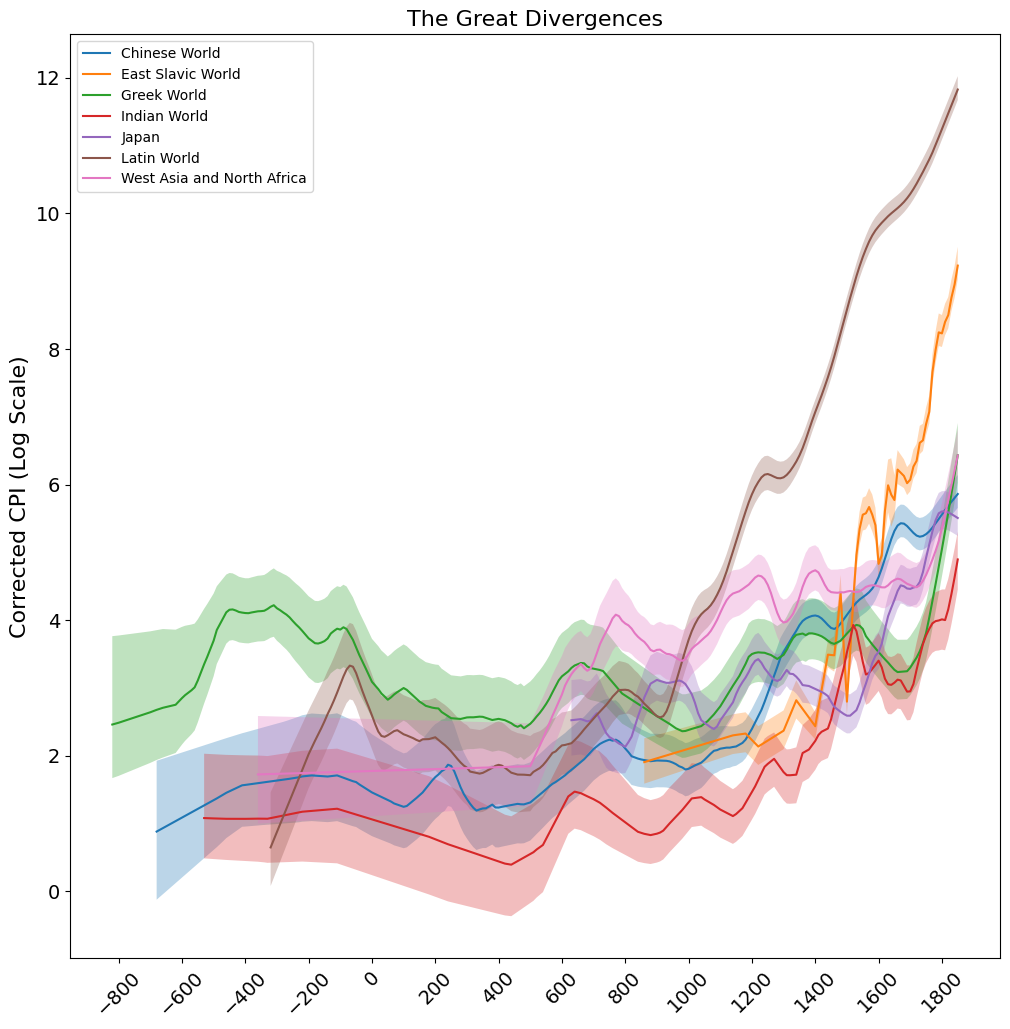

In [52]:


# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log


# # Define your color scheme
# colors = {
#     "Western Europe": "#00008b",
# }

fig, ax = plt.subplots(figsize=(12, 12))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)


    n = 0.1

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=n)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=n)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=n)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region)

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], alpha=0.3)


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('The Great Divergences', fontsize = 16)
ax.legend()
plt.show()



In [53]:
list(set(df_cultura['region_name']))

['Italy',
 'Nordic countries',
 'East Slavic',
 'France',
 'German world',
 'Persian world',
 'Japan',
 'Indian world',
 'Low countries',
 'Latin World',
 'Greek World',
 'United Kingdom',
 'Arabic world',
 'Portugal',
 'Central Europe',
 'MENA',
 'Chinese world',
 'Korea',
 'world',
 'Greek Latin',
 'Spain']